In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import bow
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
def decode(x):
    return 1 if x=='positive' else 2 if x=='neutral' else 0
def punc(arr):
    return [text.replace('""', '') for text in arr]

class ModelTrainer:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.best_model = None
    
    def train_logistic_regression(self, X_train, y_train, X_val, y_val):
        """
        Train Logistic Regression with hyperparameter tuning.
        
        Hyperparameters to tune:
        - C: Regularization strength [0.1, 1.0, 10.0]
          C < 1: More regularization (simpler model)
          C > 1: Less regularization (complex model)
        
        Returns: (trained_model, metrics_dict)
        """
        param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 3, 5, 10],
                      'solver':['lbfgs','saga'],
                      'penalty':['l1','l2']
                      }
        
                    #  'penalty':['l1','l2']
        lr = LogisticRegression(
            max_iter=5000,
            random_state=42
        )

        grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy',n_jobs=1)
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)
        
        metrics = self._calculate_metrics(y_val, y_pred)
        self.models['Logistic Regression'] = best_model
        self.results['Logistic Regression'] = metrics
        
        return best_model, metrics
    
    def train_naive_bayes(self, X_train, y_train, X_val, y_val):
        """
        Train Naive Bayes (no hyperparameter tuning needed).
        Works well with sparse text features.
        
        Returns: (trained_model, metrics_dict)
        """
        nb = MultinomialNB()
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_val)
        
        metrics = self._calculate_metrics(y_val, y_pred)
        self.models['Naive Bayes'] = nb
        self.results['Naive Bayes'] = metrics
        
        return nb, metrics
    
    def train_knn(self, X_train, y_train, X_val, y_val):
        """
        Train K-Nearest Neighbors with hyperparameter tuning.
        
        Hyperparameters to tune:
        - n_neighbors: [3, 5, 7]
          k=3: More complex, follows data closely
          k=7: Simpler, more stable
        - metric: 'cosine' (better for sparse text)
        
        Returns: (trained_model, metrics_dict)
        """
        param_grid = {'n_neighbors': [3, 5, 7,10]}
        knn = KNeighborsClassifier(metric='cosine')
        grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val)
        
        metrics = self._calculate_metrics(y_val, y_pred)
        self.models['KNN'] = best_model
        self.results['KNN'] = metrics
        
        return best_model, metrics
    
    def _calculate_metrics(self, y_true, y_pred):
        """Calculate all evaluation metrics."""
        accuracy = accuracy_score(y_true, y_pred)
        precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        return {
            'accuracy': accuracy,
            'precision': precision_weighted,
            'recall': recall_weighted,
            'f1': f1_weighted,
            'confusion_matrix': confusion_matrix(y_true, y_pred)
        }
    
    def compare_models(self):
        """Create comparison table and visualizations."""
        df_results = pd.DataFrame(self.results).T
        return df_results


In [3]:
f=pd.read_csv('all-data.csv',names=['sentiment','feedback'],encoding_errors='ignore')
obj=ModelTrainer()
vect=bow.FeatureExtractor()
x=vect.fit_transform_tfidf(punc(f['feedback'].to_numpy()))[0]
y=f['sentiment'].apply(decode).to_numpy()
print(x.shape,y.shape)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y)
obj.train_logistic_regression(x_train,y_train,x_test,y_test)
print("logistic_regression trained")
obj.train_naive_bayes(x_train,y_train,x_test,y_test)
print("naive_bayes trained")
obj.train_knn(x_train,y_train,x_test,y_test)
print("knn trained")

(4846, 10000) (4846,)


C:\Users\dhrub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\dhrub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\dhrub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\dhrub\AppDa

logistic_regression trained
naive_bayes trained
knn trained


                     accuracy precision    recall        f1
Logistic Regression  0.768041  0.762882  0.768041  0.761383
Naive Bayes          0.707216  0.713427  0.707216   0.66314
KNN                  0.704124   0.69003  0.704124  0.691833
[[ 67  22  32]
 [ 10 166  97]
 [ 12  52 512]]


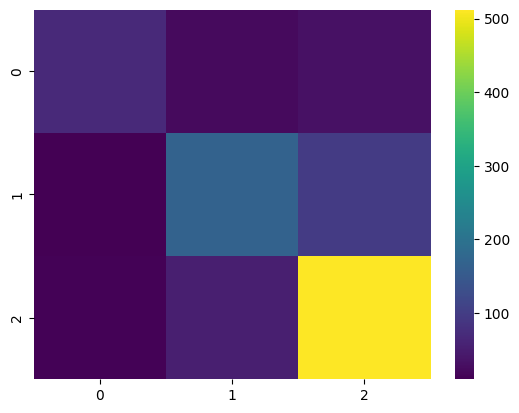

In [6]:
results=obj.compare_models()[['accuracy','precision','recall','f1']]
print(results)
print(obj.results['Logistic Regression']['confusion_matrix'])
sns.heatmap(obj.results['Logistic Regression']['confusion_matrix'],cmap='viridis')
plt.show()